In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "subtract_lepphi_0_2pi_Wl_output"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  100000 

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

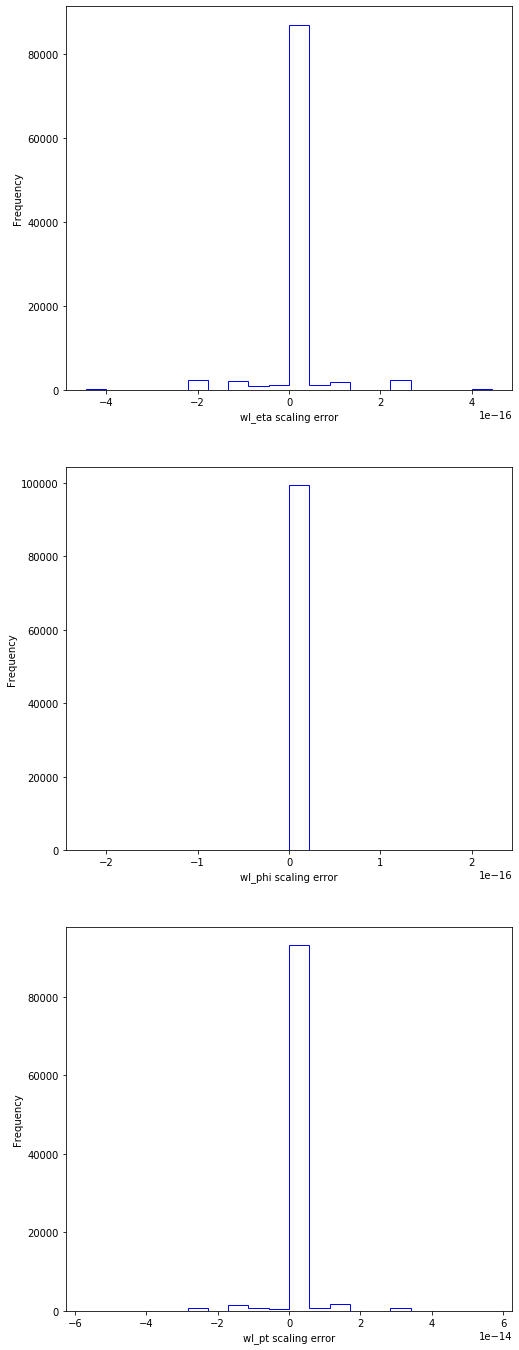

In [8]:
# Test inverse scaling

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(80000, 36) (80000, 3)
(20000, 36) (20000, 3)


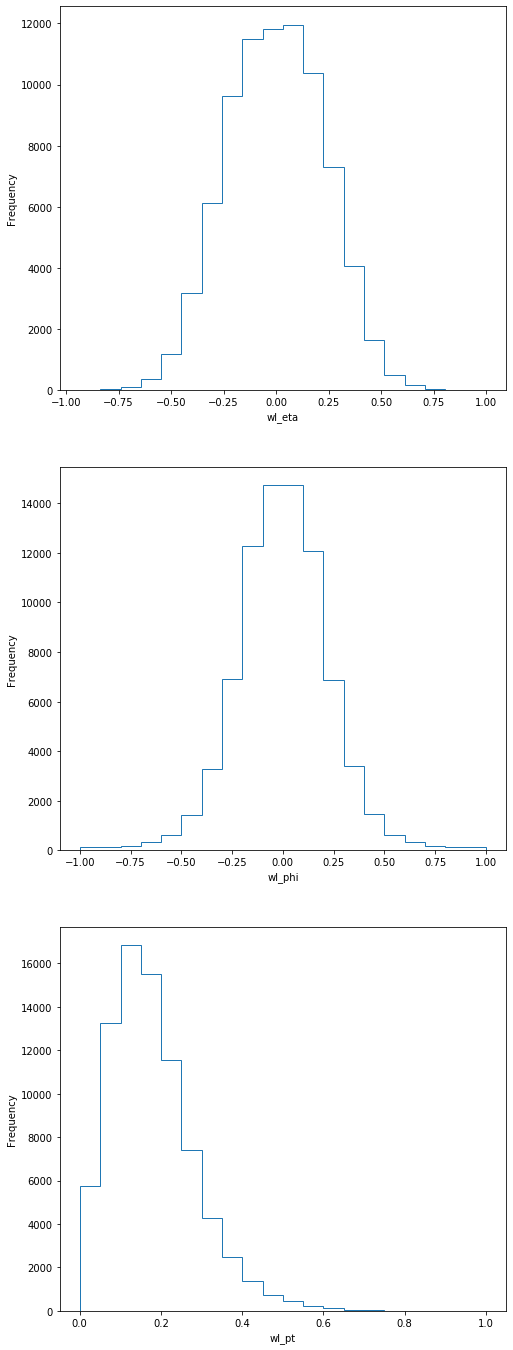

In [11]:
# Histograms of output variables 
show = True

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], 20, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

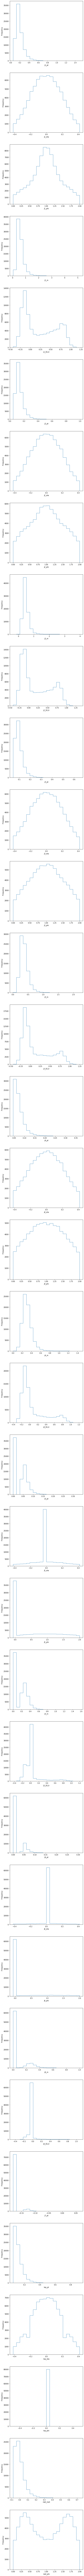

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [15]:
# Fit model

Epochs= 4096

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0530 - mse: 0.0463 - val_loss: 0.0516 - val_mse: 0.0449
Epoch 2/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0512 - mse: 0.0445 - val_loss: 0.0498 - val_mse: 0.0431
Epoch 3/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0494 - mse: 0.0427 - val_loss: 0.0480 - val_mse: 0.0413
Epoch 4/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0477 - mse: 0.0411 - val_loss: 0.0465 - val_mse: 0.0398
Epoch 5/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0464 - mse: 0.0397 - val_loss: 0.0452 - val_mse: 0.0386
Epoch 6/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0453 - mse: 0.0387 - val_loss: 0.0443 - val_mse: 0.0377
Epoch 7/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0444 - mse: 0.0378 - val_loss: 0.0435 - val_mse: 0.0369
Epoch 8/4096
125/125 [==============================] - 1s 5ms

Epoch 62/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0233 - mse: 0.0172 - val_loss: 0.0230 - val_mse: 0.0169
Epoch 63/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0232 - mse: 0.0172 - val_loss: 0.0230 - val_mse: 0.0169
Epoch 64/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0232 - mse: 0.0171 - val_loss: 0.0229 - val_mse: 0.0168
Epoch 65/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0231 - mse: 0.0170 - val_loss: 0.0228 - val_mse: 0.0168
Epoch 66/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0231 - mse: 0.0170 - val_loss: 0.0228 - val_mse: 0.0167
Epoch 67/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0230 - mse: 0.0169 - val_loss: 0.0227 - val_mse: 0.0167
Epoch 68/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0229 - mse: 0.0169 - val_loss: 0.0227 - val_mse: 0.0166
Epoch 69/4096
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0209 - mse: 0.0153 - val_loss: 0.0208 - val_mse: 0.0152
Epoch 123/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0153 - val_loss: 0.0207 - val_mse: 0.0151
Epoch 124/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0152 - val_loss: 0.0207 - val_mse: 0.0151
Epoch 125/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0152 - val_loss: 0.0207 - val_mse: 0.0151
Epoch 126/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0152 - val_loss: 0.0206 - val_mse: 0.0151
Epoch 127/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0207 - mse: 0.0152 - val_loss: 0.0206 - val_mse: 0.0151
Epoch 128/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0207 - mse: 0.0151 - val_loss: 0.0206 - val_mse: 0.0150
Epoch 129/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0141 - val_loss: 0.0193 - val_mse: 0.0142
Epoch 183/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0141 - val_loss: 0.0193 - val_mse: 0.0141
Epoch 184/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0141 - val_loss: 0.0193 - val_mse: 0.0141
Epoch 185/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0141 - val_loss: 0.0193 - val_mse: 0.0141
Epoch 186/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0141 - val_loss: 0.0193 - val_mse: 0.0141
Epoch 187/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0140 - val_loss: 0.0192 - val_mse: 0.0141
Epoch 188/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0140 - val_loss: 0.0192 - val_mse: 0.0141
Epoch 189/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0134 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 243/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0134 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 244/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0134 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 245/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0134 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 246/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0133 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 247/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0133 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 248/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0133 - val_loss: 0.0183 - val_mse: 0.0135
Epoch 249/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0129 - val_loss: 0.0177 - val_mse: 0.0131
Epoch 303/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0129 - val_loss: 0.0177 - val_mse: 0.0131
Epoch 304/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0129 - val_loss: 0.0177 - val_mse: 0.0131
Epoch 305/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0129 - val_loss: 0.0176 - val_mse: 0.0131
Epoch 306/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0129 - val_loss: 0.0176 - val_mse: 0.0131
Epoch 307/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0129 - val_loss: 0.0176 - val_mse: 0.0131
Epoch 308/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0129 - val_loss: 0.0176 - val_mse: 0.0131
Epoch 309/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0169 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 363/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0169 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 364/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0169 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 365/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0169 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 366/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0168 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 367/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0168 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 368/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0168 - mse: 0.0126 - val_loss: 0.0171 - val_mse: 0.0128
Epoch 369/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 423/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 424/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 425/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 426/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 427/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0164 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 428/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0163 - mse: 0.0123 - val_loss: 0.0167 - val_mse: 0.0126
Epoch 429/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - mse: 0.0121 - val_loss: 0.0164 - val_mse: 0.0125
Epoch 483/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - mse: 0.0121 - val_loss: 0.0164 - val_mse: 0.0125
Epoch 484/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - mse: 0.0121 - val_loss: 0.0164 - val_mse: 0.0125
Epoch 485/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - mse: 0.0121 - val_loss: 0.0164 - val_mse: 0.0125
Epoch 486/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0160 - mse: 0.0121 - val_loss: 0.0164 - val_mse: 0.0125
Epoch 487/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0159 - mse: 0.0120 - val_loss: 0.0163 - val_mse: 0.0124
Epoch 488/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0159 - mse: 0.0120 - val_loss: 0.0163 - val_mse: 0.0124
Epoch 489/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 543/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 544/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 545/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 546/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 547/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0119 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 548/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0156 - mse: 0.0118 - val_loss: 0.0161 - val_mse: 0.0123
Epoch 549/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0159 - val_mse: 0.0122
Epoch 603/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0159 - val_mse: 0.0122
Epoch 604/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0158 - val_mse: 0.0122
Epoch 605/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0158 - val_mse: 0.0122
Epoch 606/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0158 - val_mse: 0.0122
Epoch 607/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0158 - val_mse: 0.0122
Epoch 608/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0153 - mse: 0.0117 - val_loss: 0.0158 - val_mse: 0.0122
Epoch 609/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0151 - mse: 0.0115 - val_loss: 0.0157 - val_mse: 0.0121
Epoch 663/4096
125/125 [==============================] - ETA: 0s - loss: 0.0150 - mse: 0.011 - 1s 5ms/step - loss: 0.0151 - mse: 0.0115 - val_loss: 0.0157 - val_mse: 0.0121
Epoch 664/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0115 - val_loss: 0.0157 - val_mse: 0.0121
Epoch 665/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0115 - val_loss: 0.0156 - val_mse: 0.0121
Epoch 666/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0115 - val_loss: 0.0156 - val_mse: 0.0121
Epoch 667/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0115 - val_loss: 0.0156 - val_mse: 0.0121
Epoch 668/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0150 - mse: 0.0115 - val_loss: 0.0156 - val_mse: 0.0121
Epoch 669/4096
125/125 [=

125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 723/4096
125/125 [==============================] - ETA: 0s - loss: 0.0148 - mse: 0.011 - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 724/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 725/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 726/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 727/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 728/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0148 - mse: 0.0114 - val_loss: 0.0155 - val_mse: 0.0121
Epoch 729/4096
125/125 [=

125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 783/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 784/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 785/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 786/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 787/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 788/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0146 - mse: 0.0113 - val_loss: 0.0153 - val_mse: 0.0120
Epoch 789/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 843/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 844/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 845/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 846/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 847/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 848/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0144 - mse: 0.0111 - val_loss: 0.0152 - val_mse: 0.0119
Epoch 849/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 903/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 904/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 905/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 906/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 907/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 908/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0142 - mse: 0.0110 - val_loss: 0.0151 - val_mse: 0.0119
Epoch 909/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 963/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 964/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 965/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 966/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 967/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 968/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0141 - mse: 0.0109 - val_loss: 0.0150 - val_mse: 0.0119
Epoch 969/4096
125/125 [==============================] - 1s 5m

125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1023/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1024/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1025/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1026/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1027/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1028/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0139 - mse: 0.0108 - val_loss: 0.0149 - val_mse: 0.0118
Epoch 1029/4096
125/125 [==============================] 

Epoch 1082/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1083/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1084/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1085/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1086/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1087/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0108 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1088/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0138 - mse: 0.0107 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1089/4096
125/125 [================

Epoch 1142/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1143/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0148 - val_mse: 0.0118
Epoch 1144/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1145/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1146/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1147/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1148/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0136 - mse: 0.0107 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1149/4096
125/125 [================

125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1202/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1203/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1204/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1205/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1206/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1207/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0135 - mse: 0.0106 - val_loss: 0.0147 - val_mse: 0.0118
Epoch 1208/4096
125/125 [==============================] 

125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1261/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1262/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1263/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1264/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1265/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1266/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0134 - mse: 0.0105 - val_loss: 0.0146 - val_mse: 0.0118
Epoch 1267/4096
125/125 [==============================] 

Epoch 1320/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1321/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1322/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1323/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1324/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1325/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1326/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0133 - mse: 0.0104 - val_loss: 0.0146 - val_mse: 0.0117
Epoch 1327/4096
125/125 [================

Epoch 1380/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1381/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1382/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1383/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1384/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1385/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1386/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0132 - mse: 0.0104 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1387/4096
125/125 [================

125/125 [==============================] - 1s 5ms/step - loss: 0.0131 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1440/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0131 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1441/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0131 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1442/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0131 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1443/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1444/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1445/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0103 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1446/4096
125/125 [==============================] 

Epoch 1499/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0130 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1500/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1501/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1502/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1503/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1504/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1505/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0129 - mse: 0.0102 - val_loss: 0.0145 - val_mse: 0.0117
Epoch 1506/4096
125/125 [================

Epoch 1559/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0102 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1560/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0102 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1561/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0102 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1562/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0102 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1563/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0102 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1564/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1565/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0128 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1566/4096
125/125 [================

Epoch 1619/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1620/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1621/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1622/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1623/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1624/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1625/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0127 - mse: 0.0101 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1626/4096
125/125 [================

Epoch 1679/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1680/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1681/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1682/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1683/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1684/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1685/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0100 - val_loss: 0.0144 - val_mse: 0.0117
Epoch 1686/4096
125/125 [================

Epoch 1739/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1740/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1741/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0126 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1742/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1743/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1744/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1745/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0144 - val_mse: 0.0118
Epoch 1746/4096
125/125 [================

Epoch 1799/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1800/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1801/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1802/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1803/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1804/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0125 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1805/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0099 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1806/4096
125/125 [================

Epoch 1859/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1860/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1861/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1862/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1863/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1864/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1865/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0124 - mse: 0.0098 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1866/4096
125/125 [================

Epoch 1919/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1920/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1921/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1922/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1923/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1924/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1925/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0123 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1926/4096
125/125 [================

Epoch 1979/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1980/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1981/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1982/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1983/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1984/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1985/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0122 - mse: 0.0097 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 1986/4096
125/125 [================

Epoch 2039/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2040/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2041/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2042/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2043/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2044/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2045/4096
125/125 [==============================] - 1s 5ms/step - loss: 0.0121 - mse: 0.0096 - val_loss: 0.0143 - val_mse: 0.0118
Epoch 2046/4096
125/125 [================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: subtract_lepphi_0_2pi_Wl_output/assets


Text(0.5, 1.0, 'MSE loss')

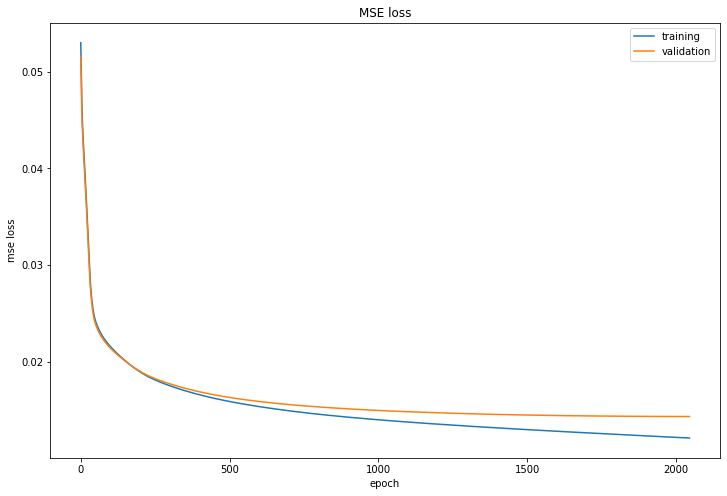

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

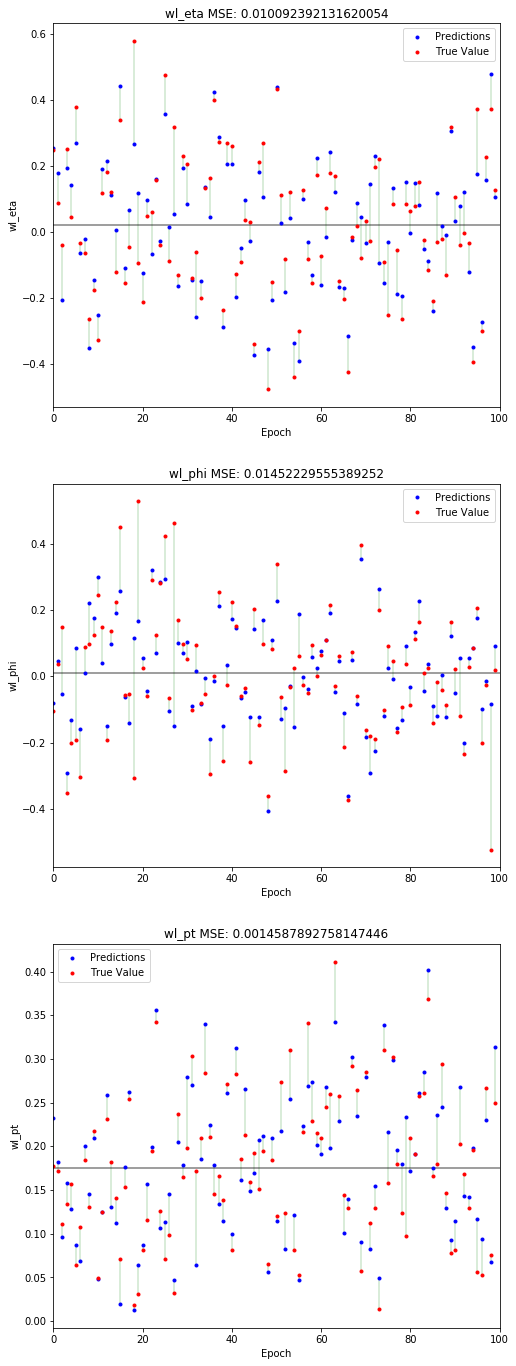

In [19]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [20]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.012011265857795451
wl_eta MSE :  0.0089193095
wl_phi MSE :  0.0249505113
wl_pt MSE :  0.0021639768


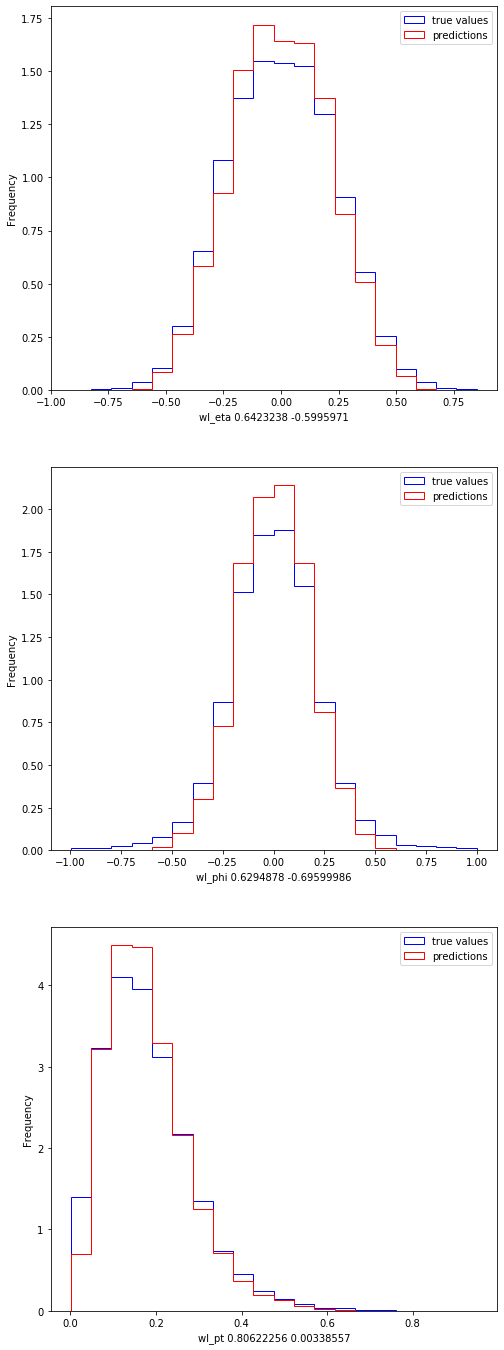

In [21]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [22]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


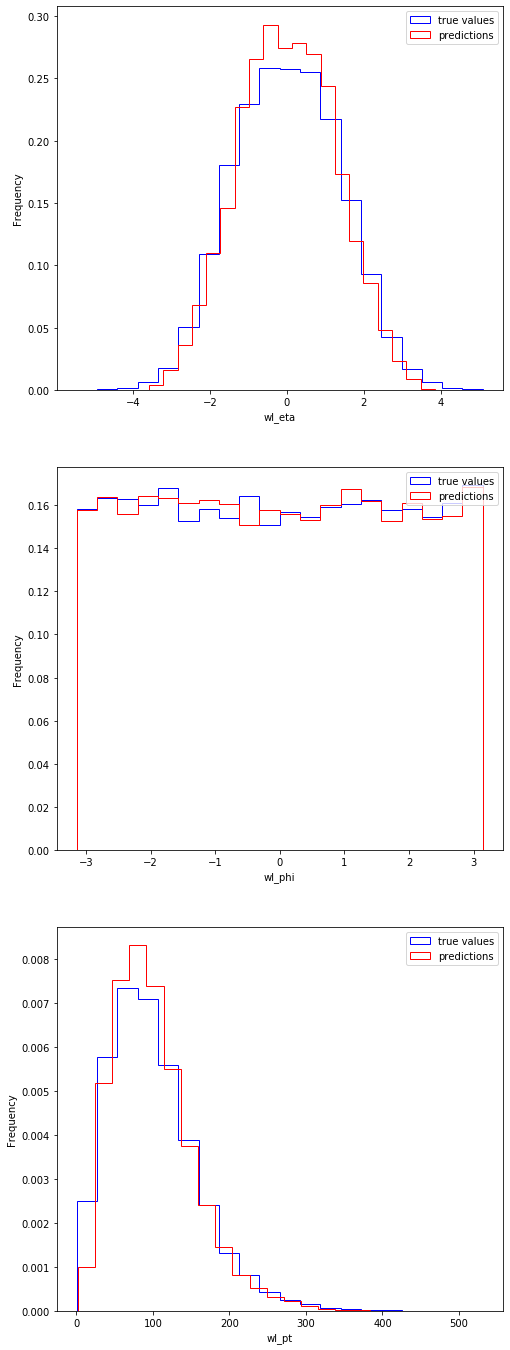

In [23]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [24]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale wl_eta MSE :  0.3194174659
Original Scale wl_phi MSE :  0.2245511026
Original Scale wl_pt MSE :  676.5854693682


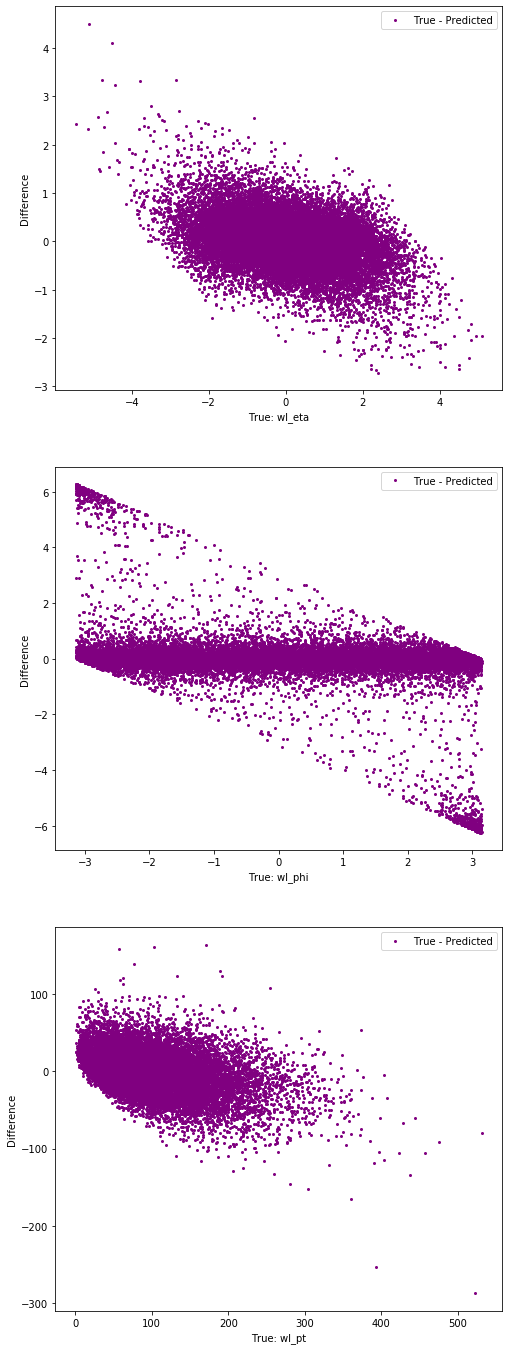

In [25]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')